<font face="Verdana, cursive, sans-serif" >
<center><H1>Anomaly Detection with PRIDIT</H1></center>

<center><H2><font color='darkred'>How to convert categorical variables to RIDIT score and implement PRIDIT </font></H2></center>

<p>This Python Jupyter Notebooks is a counter-part of <a href="https://nbviewer.jupyter.org/github/swatakit/SAS-Tools/blob/master/Anomaly%20Detection%20with%20PRIDIT%20-%20SAS.ipynb"><b>Anomaly Detection with PRIDIT - SAS</b></a>.
    
Note that we follows Bross(1958) for RIDIT transformation - the results maybe different than SAS due rounding error and RIDIT methodology used in PROC FREQ

<font face="Verdana, cursive, sans-serif" >
<b>Import libraries</b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

<font face="Verdana, cursive, sans-serif" >
<b>Read data</b>

In [2]:
rule_filename = './sasdata/rules_data.sas7bdat'
rule_columns_start = 'R1'
rule_columns_end = 'R4'
data = pd.read_sas(rule_filename, encoding='iso-8859-1')
data.head()

,R1,R2,R3,R4
0,1.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


<font face="Verdana, cursive, sans-serif" >
<b>RIDIT transformation - Bross(1958)</b>

In [3]:
#Do RIDIT transformation

rules = data.loc[:,rule_columns_start:rule_columns_end]
dict_ridits_1 = {}
dict_ridits_0 = {}

for rule in rules:
    try:
        r = data[rule].value_counts()
        p_1 = r[1]/np.sum(r)
        p_0 = r[0]/np.sum(r)
        ridit_1 = (0.5 * p_1)
        ridit_0 = (p_1+0.5*p_0)
        #replace 0,1 with ridits
        rule_name='P_'+str(rule)
        data[rule_name]=data[rule].map({1:ridit_1,0:ridit_0})
        dict_ridits_1.update({str(rule):ridit_1})
        dict_ridits_0.update({str(rule):ridit_0})
        
    except :
        #there maybe some problem with some rules, that is, a rule with all zero.
        print(bold,red,"Warning!! Problem converting rule = {}".format(rule))

print("Class - 1")
print("="*10)
for key,value in dict_ridits_1.items():
    print(key,' ',value )
print("Class - 0")
print("="*10)
for key,value in dict_ridits_0.items():
    print(key,' ',value )
    
print("="*60)
print(data.head())

Class - 1
R1   0.16666666666666666
R2   0.21666666666666667
R3   0.18333333333333332
R4   0.23333333333333334
Class - 0
R1   0.6666666666666666
R2   0.7166666666666667
R3   0.6833333333333333
R4   0.7333333333333334
    R1   R2   R3   R4      P_R1      P_R2      P_R3      P_R4
0  1.0  1.0  0.0  1.0  0.166667  0.216667  0.683333  0.233333
1  0.0  1.0  0.0  0.0  0.666667  0.216667  0.683333  0.733333
2  1.0  1.0  0.0  0.0  0.166667  0.216667  0.683333  0.733333
3  0.0  1.0  1.0  1.0  0.666667  0.216667  0.183333  0.233333
4  0.0  0.0  0.0  0.0  0.666667  0.716667  0.683333  0.733333


<font face="Verdana, cursive, sans-serif" >
<b>PRIDIT - Brockett et al(2002)</b>

In [4]:
keys_p = ['P_'+ x for x in dict_ridits_1.keys()]

In [5]:
#Gets only  the good rules
ridits = data.loc[:,keys_p].values

#Determine how many components to retain by Kaiser rule, eigen values>1
cor_mat = np.corrcoef(ridits.T)
eig_vals,eig_vecs = np.linalg.eig(cor_mat)
n_pca = np.count_nonzero(eig_vals>1)
print("Eigen values : \n",eig_vals)
print("\nTotal components to keep : {}".format(n_pca))

Eigen values : 
 [1.38245392 1.07525733 0.70150042 0.84078832]

Total components to keep : 2


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_pca)
pca.fit(ridits)
pridit =  pca.transform(ridits)


In [7]:
pridit_df = pd.DataFrame(pridit)
pridit_df.columns = ['PRIDIT1','PRIDIT2']

(array([5., 9., 6., 3., 5., 2.]),
 array([-0.40925362, -0.2434112 , -0.07756877,  0.08827365,  0.25411607,
         0.4199585 ,  0.58580092]),
 <a list of 6 Patch objects>)

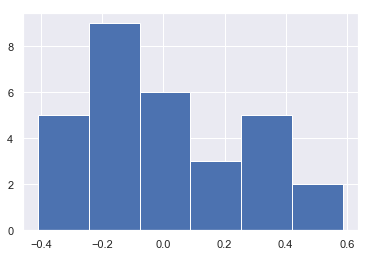

In [8]:
plt.hist(pridit_df.loc[:,'PRIDIT1'].dropna(),density=False,bins=6)